# Set up

In [9]:
import torch
import pandas as pd
import numpy as np
import tqdm as tqdm

import matplotlib.pyplot as plt

import arviz as az
import seaborn as sns

import os
import scipy.stats as stats

from statsmodels.graphics.tsaplots import plot_acf
import statsmodels


from pyro.ops.stats import (
    gelman_rubin,
    split_gelman_rubin,
    autocorrelation,
    effective_sample_size,
    resample,
    quantile,
    weighed_quantile
)

In [2]:
Device = 'cpu'

# Data

In [3]:
X_train = pd.read_csv('Data/X_train.csv', header=None, delimiter=',').values
X_test = pd.read_csv('Data/X_test.csv', header=None, delimiter=',').values

Y_train_21 = pd.read_csv('Data/Y_train_std_21.csv', header=None, delimiter=',').values
Y_test_21 = pd.read_csv('Data/Y_test_std_21.csv', header=None, delimiter=',').values

Y_train_std = pd.read_csv('Data/Y_train_std.csv', header=None, delimiter=',').values
Y_test_std = pd.read_csv('Data/Y_test_std.csv', header=None, delimiter=',').values


train_x = torch.tensor(X_train, dtype=torch.float32)
test_x = torch.tensor(X_test, dtype=torch.float32)

train_y_21 = torch.tensor(Y_train_21, dtype=torch.float32)
test_y_21 = torch.tensor(Y_test_21, dtype=torch.float32)

train_y = torch.tensor(Y_train_std, dtype=torch.float32)
test_y = torch.tensor(Y_test_std, dtype=torch.float32)


# Emulator Result

In [4]:
loaded_samples_chain1 = torch.load("mcmc_samples_2.pt", map_location=Device)

/tmp/ipykernel_726362/1572402610.py:1: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  loaded_samples_chain1 = torch.load("mcmc_samples_2.pt", map_location=Device)


In [5]:
loaded_samples_chain2 = torch.load("mcmc_samples_1.pt", map_location=Device)

/tmp/ipykernel_726362/2405443910.py:1: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  loaded_samples_chain2 = torch.load("mcmc_samples_1.pt", map_location=Device)


# MCMC V

In [7]:
autocorrelation(loaded_samples_chain1['param_0'], dim=0)

tensor([ 1.0000,  0.2981,  0.1796,  ...,  0.0452, -0.3253,  0.0791])

In [11]:
statsmodels.tsa.stattools.acf(loaded_samples_chain1['param_0'], nlags=1199)

array([ 1.00000000e+00,  2.97820683e-01,  1.79272283e-01, ...,
        1.12942499e-04, -5.42199687e-04,  6.59305065e-05])

param_0: R-hat = 1.001, split R-hat = 1.001, ESS = 1321.8


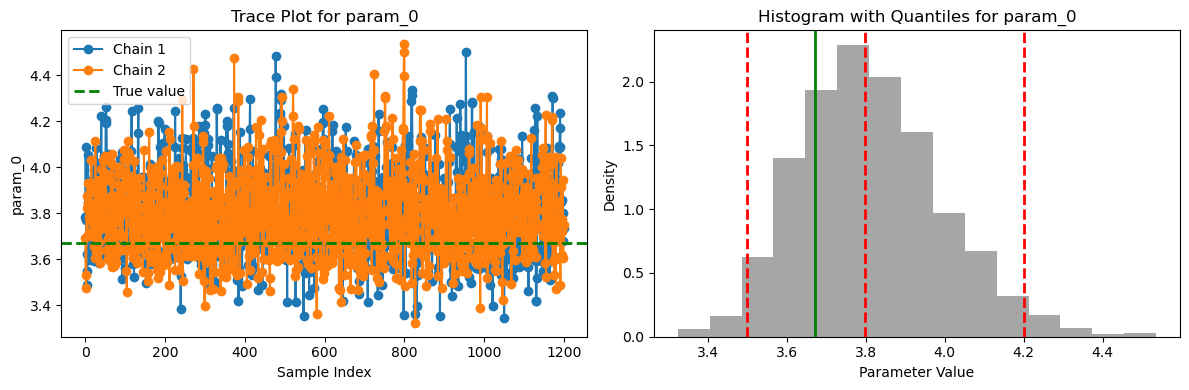

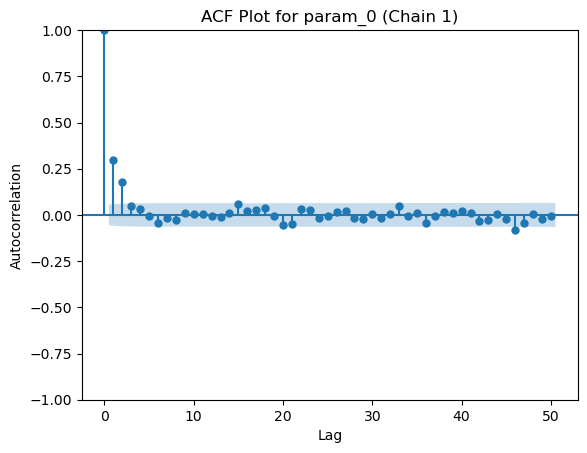

param_1: R-hat = 1.002, split R-hat = 1.002, ESS = 1219.5


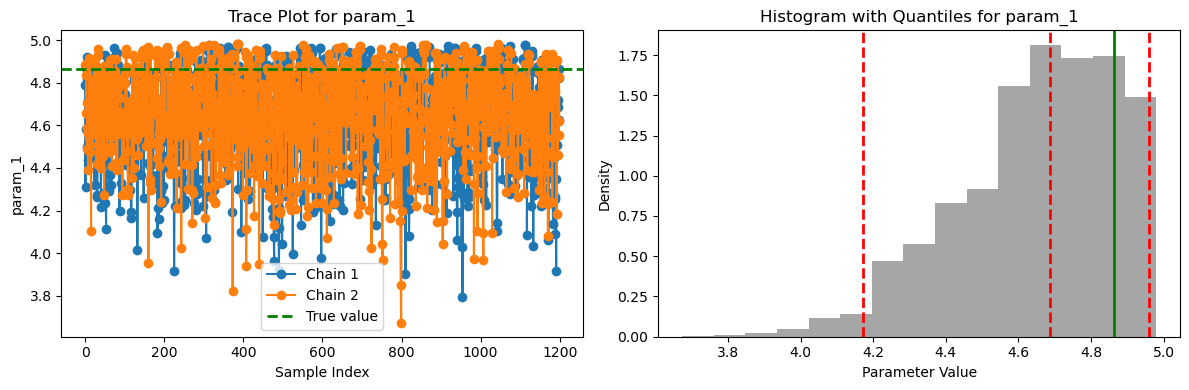

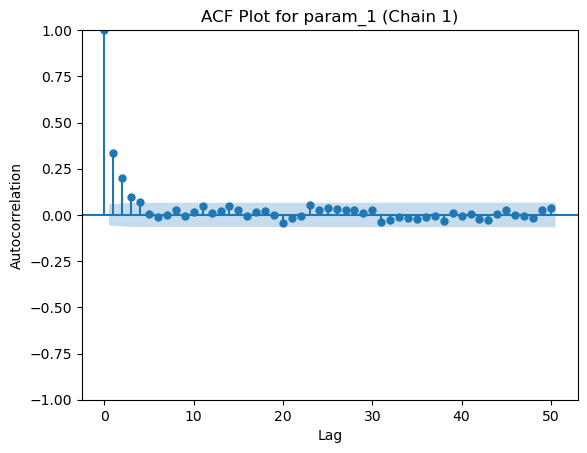

param_2: R-hat = 1.001, split R-hat = 1.001, ESS = 875.7


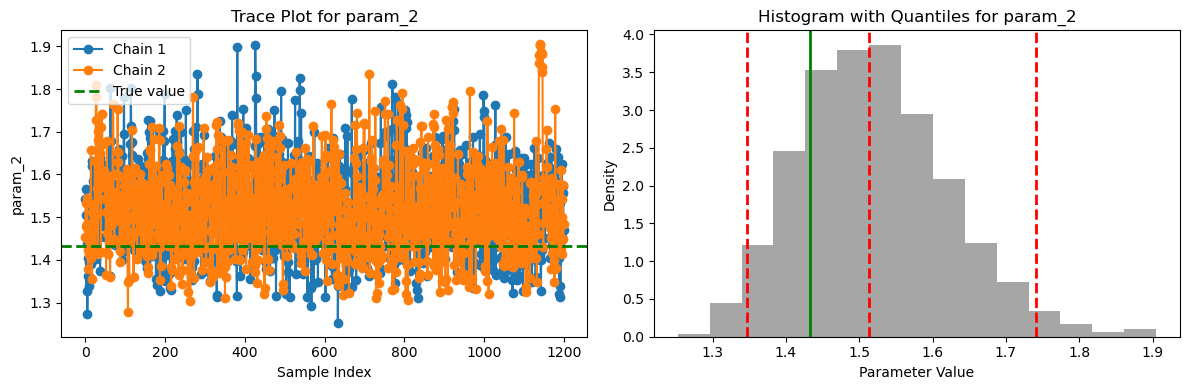

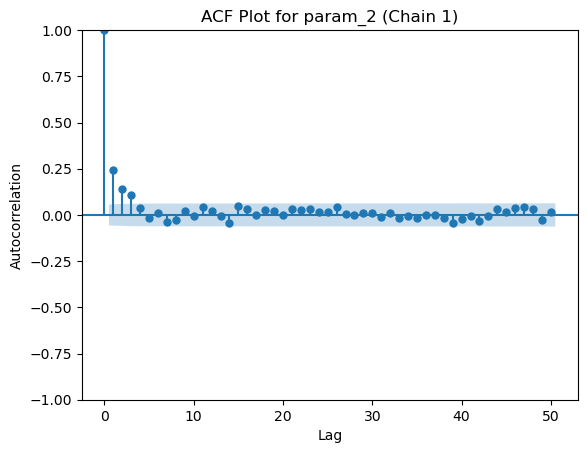

param_3: R-hat = 1.001, split R-hat = 1.001, ESS = 983.1


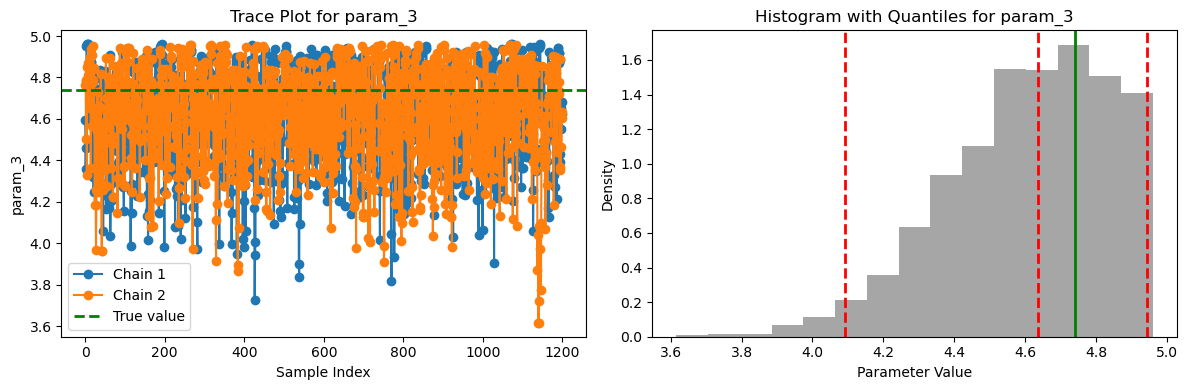

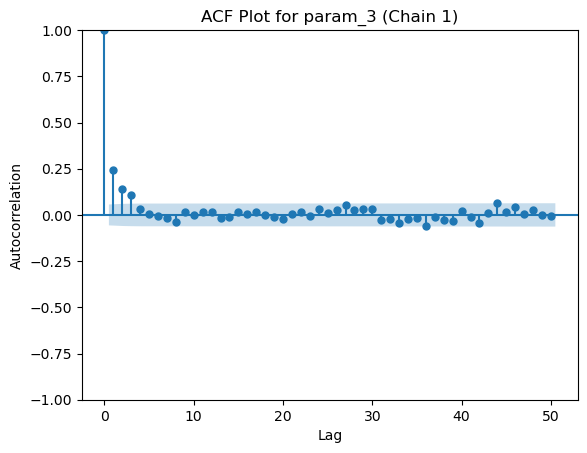

param_4: R-hat = 1.002, split R-hat = 1.004, ESS = 1210.2


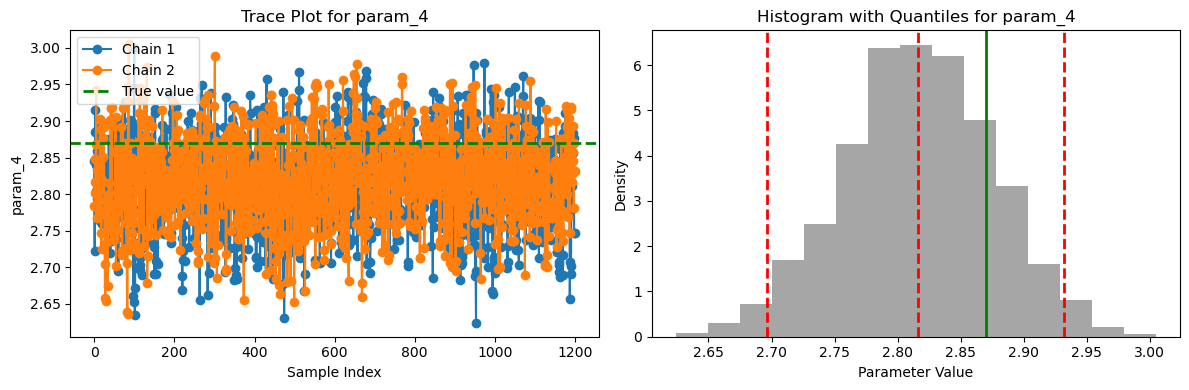

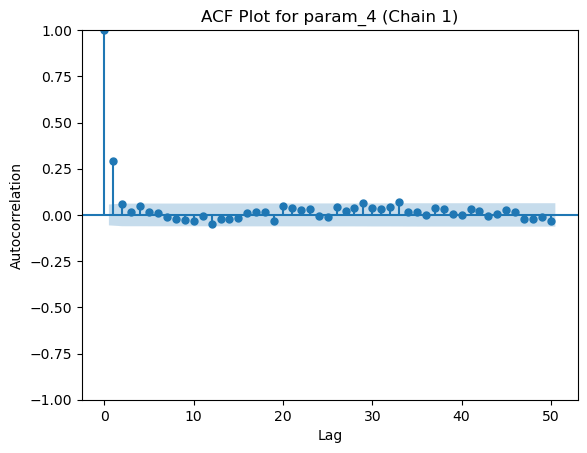

param_5: R-hat = 1.002, split R-hat = 1.004, ESS = 1443.1


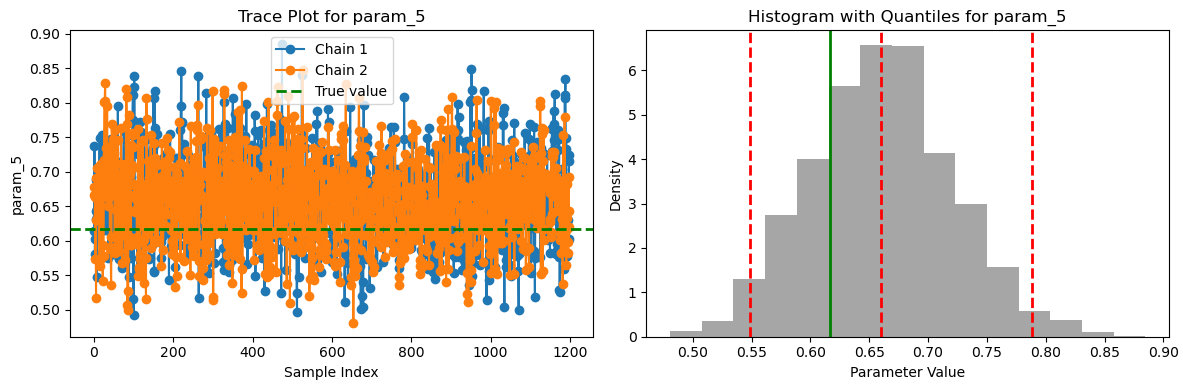

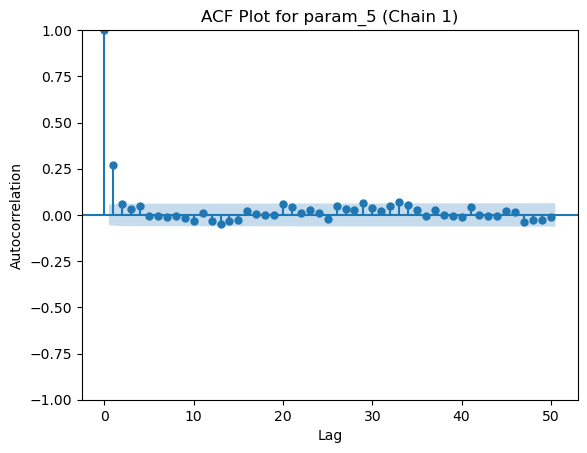

param_6: R-hat = 1.000, split R-hat = 1.001, ESS = 1005.7


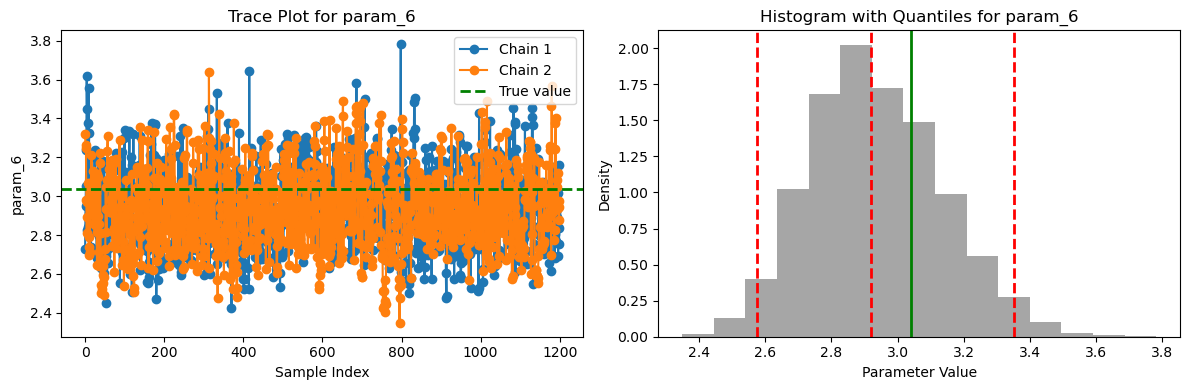

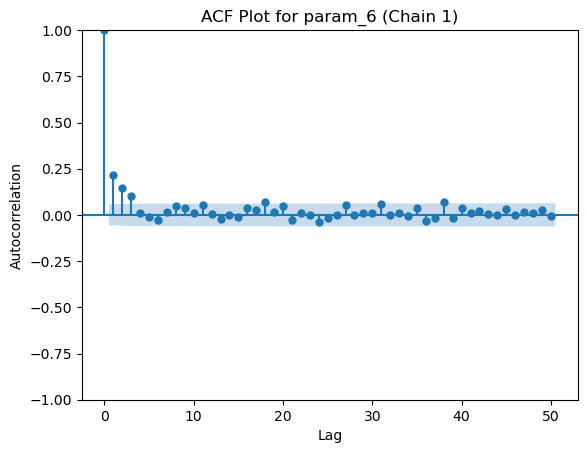

param_7: R-hat = 1.000, split R-hat = 1.001, ESS = 1025.8


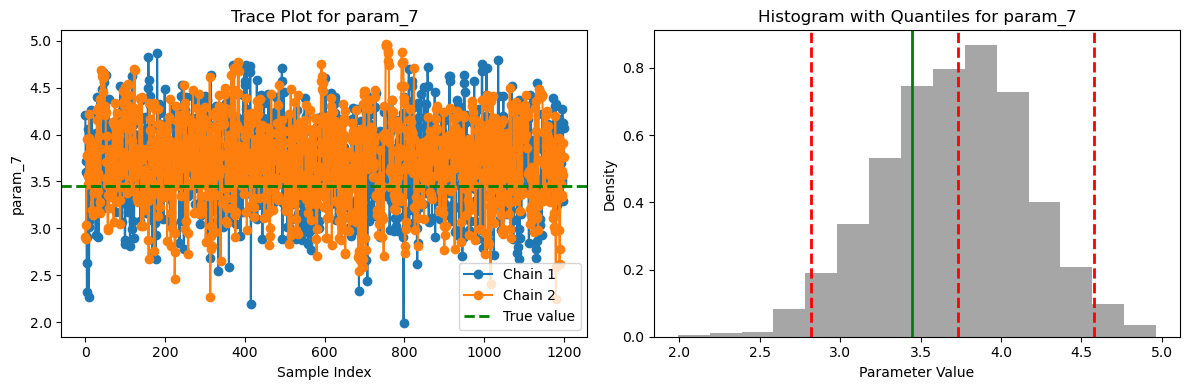

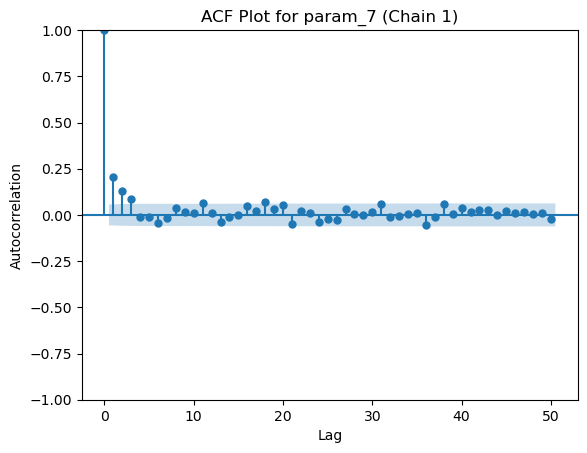

param_8: R-hat = 1.000, split R-hat = 1.001, ESS = 890.4


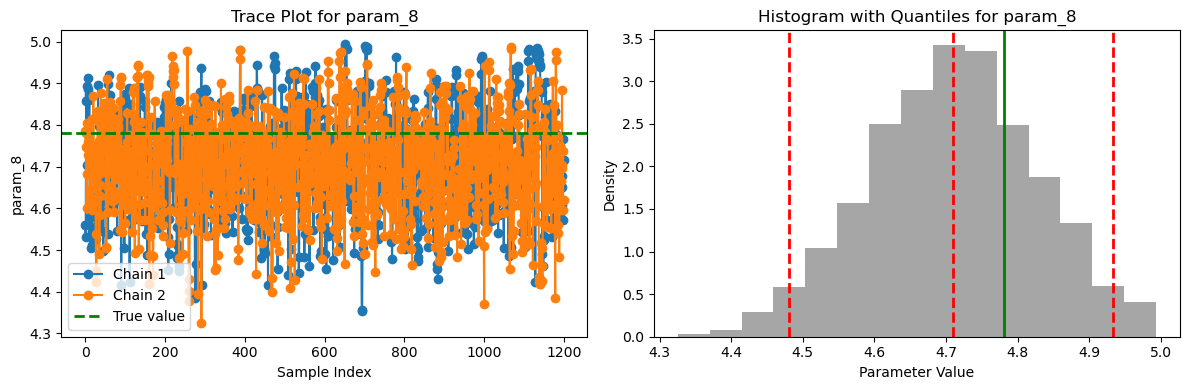

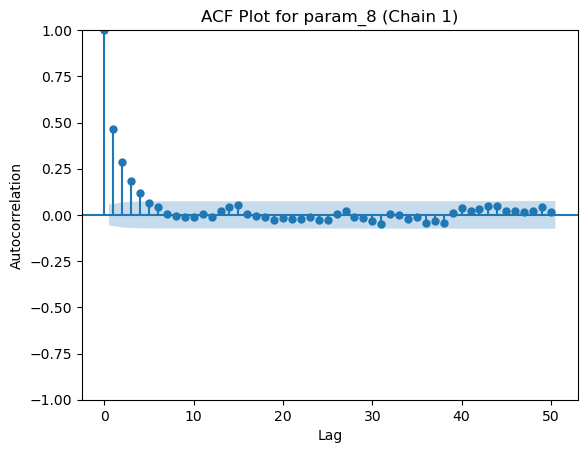

param_9: R-hat = 1.001, split R-hat = 1.001, ESS = 929.4


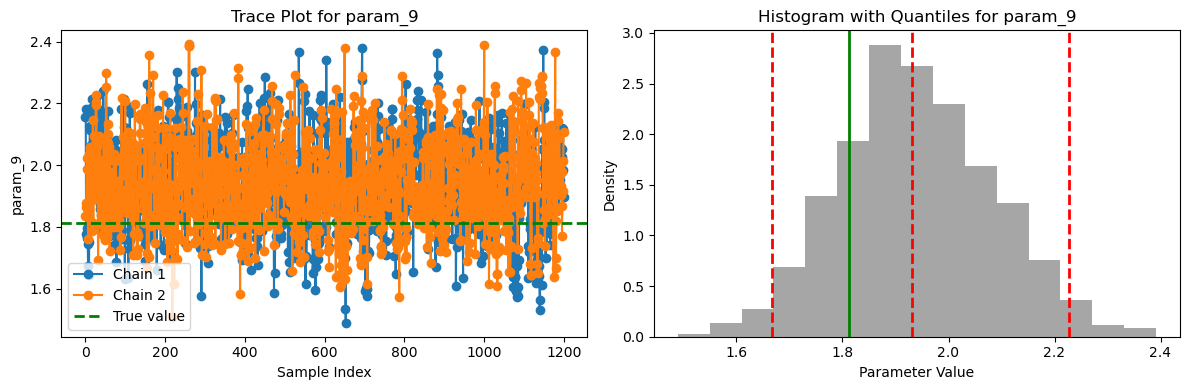

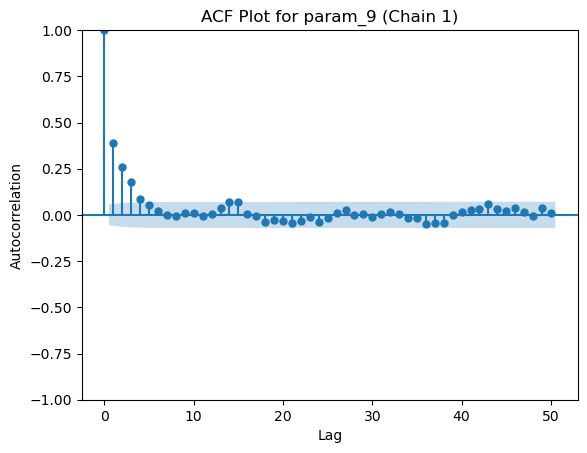

In [16]:
true_params_tensor = test_x[0]

param_names = sorted(list(loaded_samples_chain1.keys()))

true_params = {name: true_params_tensor[i].item() for i, name in enumerate(param_names)}


mcmc_samples = {}
for param in loaded_samples_chain1.keys():
    mcmc_samples[param] = torch.stack([loaded_samples_chain1[param], loaded_samples_chain2[param]])

n_chains = 2
diagnostics_results = {}

for param, samples_chains in mcmc_samples.items():
    true_value = true_params[param]
    n_samples = samples_chains.shape[1]
    
    # rhat ...
    rhat = gelman_rubin(samples_chains, chain_dim=0, sample_dim=1)
    split_rhat = split_gelman_rubin(samples_chains, chain_dim=0, sample_dim=1)
    ess = effective_sample_size(samples_chains, chain_dim=0, sample_dim=1)
    
    diagnostics_results[param] = {
         "R-hat": rhat.item(),
         "Split R-hat": split_rhat.item(),
         "Effective Sample Size": ess.item()
    }
    print(f"{param}: R-hat = {rhat.item():.3f}, split R-hat = {split_rhat.item():.3f}, ESS = {ess.item():.1f}")
    
    # Trace Plot
    plt.figure(figsize=(12, 4))
    plt.subplot(1, 2, 1)
    for i in range(n_chains):
         plt.plot(samples_chains[i].numpy(), marker='o', label=f"Chain {i+1}")
    plt.axhline(true_value, color='green', linestyle='--', linewidth=2, label="True value")
    plt.title(f"Trace Plot for {param}")
    plt.xlabel("Sample Index")
    plt.ylabel(param)
    plt.legend()
    
    # Quantiles
    plt.subplot(1, 2, 2)
    all_samples = samples_chains.flatten()
    plt.hist(all_samples.numpy(), bins=15, density=True, alpha=0.7, color='gray')
    plt.axvline(true_value, color='green', linestyle='-', linewidth=2, label="True value")
    qs = quantile(all_samples, probs=[0.025, 0.5, 0.975], dim=0)
    for q in qs:
         plt.axvline(q.item(), color='red', linestyle='--', linewidth=2)
    plt.title(f"Histogram with Quantiles for {param}")
    plt.xlabel("Parameter Value")
    plt.ylabel("Density")
    plt.tight_layout()
    plt.show()

    # ACF
    plot_acf(samples_chains[0].numpy(), lags=50)
    plt.xlabel("Lag")
    plt.ylabel("Autocorrelation")
    plt.title(f"ACF Plot for {param} (Chain 1)")
    plt.show()

    
#     acf = autocorrelation(mcmc_samples[param], dim=0)
#     plt.figure(figsize=(6, 4))
#     plt.plot(acf.numpy(), marker='o')
#     plt.title(f"Autocorrelation for {param} (Chain 1)")
#     plt.xlabel("Lag")
#     plt.ylabel("Autocorrelation")
#     plt.show()
    
    # Weighed Quantile
    # 使用均匀权重（对数权重为0）时，带权重分位数应与普通分位数一致
#     log_weights = torch.zeros_like(samples)
#     wq = weighed_quantile(samples, probs=[0.025, 0.5, 0.975], log_weights=log_weights, dim=0)
#     print(f"{param} weighed quantiles: {wq}\n")
